In [1]:
%load_ext autoreload
%autoreload 2
%autosave 180

Autosaving every 180 seconds


In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from utils import *
from model import *
import pandas as pd

np.random.seed(0)
torch.manual_seed(0)
latent_size = 10
batch_size = 100
validation_split = 0.8
target = 0           

use_dataset = "MNIST"

In [3]:
if use_dataset == "MNIST":

  transforms = torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                  (0.1307,), (0.3081,))])


  dataset =   torchvision.datasets.MNIST('./files/', train=True, download=True,
                              transform=transforms)


  rand_indeces = np.random.permutation(range(len(dataset.data)))
  train_ind = rand_indeces[:int(len(dataset.data)*validation_split)]
  valid_ind = rand_indeces[int(len(dataset.data)*validation_split):]

  train_data, train_labels = dataset.data[train_ind],dataset.targets[train_ind] 

  val_data, val_labels = dataset.data[valid_ind],dataset.targets[valid_ind] 

  val_data = torch.reshape(val_data,(-1,*dataset.data.shape[1:])).numpy()
  #val_labels = np.array(val_labels.numpy() == target,np.int)


  test_dataset = torchvision.datasets.MNIST('./files/', train=False, download=True,transform=transforms)



  test_loader = torch.utils.data.DataLoader(test_dataset  , batch_size=batch_size, shuffle=True)

                    
  normal_data = [np.expand_dims(train_data[i],2) if train_labels[i]==target else None for i in range(len(train_data))]

  normal_data = list(filter(lambda x: x is not None, normal_data))

elif use_dataset == "CIFAR10":

  transforms = torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


  dataset =   torchvision.datasets.CIFAR10('./files/', train=True, download=True,
                              transform=transforms)


  rand_indeces = np.random.permutation(range(len(dataset.data)))
  train_ind = rand_indeces[:int(len(dataset.data)*validation_split)]
  valid_ind = rand_indeces[int(len(dataset.data)*validation_split):]


  train_data, train_labels = torch.Tensor(dataset.data)[train_ind],torch.Tensor(dataset.targets)[train_ind] 
  val_data, val_labels = torch.Tensor(dataset.data)[valid_ind],torch.Tensor(dataset.targets)[valid_ind] 
  val_data = torch.reshape(val_data,(-1,*dataset.data.shape[1:])).numpy()
  test_dataset = torchvision.datasets.CIFAR10('./files/', train=False, download=True,transform=transforms)



  test_loader = torch.utils.data.DataLoader(test_dataset  , batch_size=batch_size, shuffle=True)

                    
  normal_data = [np.array(train_data[i]) if train_labels[i]==target else None for i in range(len(train_data))]

  normal_data = list(filter(lambda x: x is not None, normal_data))
  pass

In [4]:
valid_loader = torch.utils.data.DataLoader(Dataset(val_data,val_labels,masks = None, transform=transforms), batch_size = batch_size)


train_loader = torch.utils.data.DataLoader(Dataset(normal_data,np.ones(len(normal_data)),masks = None, transform=transforms), batch_size = batch_size)

In [5]:
from model import *

gen = ConvGenerator(latent_size = latent_size,normalize = False,)
disc = ConvDiscriminator(normalize= False)

device = "cuda"
gen.to(device)
disc.to(device)


ConvDiscriminator(
  (discriminator): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(4, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(32, 1, kernel_size=(4,

In [6]:
z = torch.randn((batch_size,latent_size))
fixed_latent = torch.reshape(z,(batch_size,latent_size,1,1)).to(device)
epochs = 30
repeats= 5
all_noreplay = []
replay = False
for seed in range(repeats):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_dataset == "MNIST":
        gen = ConvGenerator(latent_size = latent_size,normalize = False)
        disc = ConvDiscriminator(normalize= False)
    elif use_dataset == "CIFAR10":
        gen = ConvGeneratorCIFAR(latent_size = latent_size,normalize = False)
        disc = ConvDiscriminatorCIFAR(normalize= False)


    device = "cuda"
    gen.to(device)
    disc.to(device)
    f1s_noreplay = fit(disc, gen, train_loader,epochs, fixed_latent, device = device,lr_d = 1e-4, lr_g = 1e-4, replay = replay, test_loader=valid_loader, run_on_test = True,batch_size = batch_size, model_name=f"novelty_gan_{use_dataset}")[-1]
    all_noreplay.append(f1s_noreplay)

|██████████| 48/48 [00:00<00:00, 65.30it/s]
Epoch [1/30], loss_g: 0.6246, loss_d: 1.3229, real_score: 0.6435, fake_score: 0.5625
Saving generated-images-0001.png
100%|██████████| 48/48 [00:00<00:00, 63.88it/s]
Epoch [2/30], loss_g: 0.7186, loss_d: 1.2621, real_score: 0.6096, fake_score: 0.5071
Saving generated-images-0002.png
100%|██████████| 48/48 [00:00<00:00, 65.44it/s]
Epoch [3/30], loss_g: 0.7122, loss_d: 1.2986, real_score: 0.5759, fake_score: 0.5058
Saving generated-images-0003.png
100%|██████████| 48/48 [00:00<00:00, 66.18it/s]
Epoch [4/30], loss_g: 0.7376, loss_d: 1.2795, real_score: 0.5531, fake_score: 0.4720
Saving generated-images-0004.png
100%|██████████| 48/48 [00:00<00:00, 66.07it/s]
Epoch [5/30], loss_g: 0.8010, loss_d: 1.2113, real_score: 0.5675, fake_score: 0.4372
Saving generated-images-0005.png
100%|██████████| 48/48 [00:00<00:00, 66.71it/s]
Epoch [6/30], loss_g: 0.8478, loss_d: 1.1432, real_score: 0.5992, fake_score: 0.4204
Saving generated-images-0006.png
100%|███

In [7]:
z = torch.randn((batch_size,latent_size))
fixed_latent = torch.reshape(z,(batch_size,latent_size,1,1)).to(device)
all_replay = []
replay = True
for seed in range(repeats):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_dataset == "MNIST":
        gen = ConvGenerator(latent_size = latent_size,normalize = False)
        disc = ConvDiscriminator(normalize= False)
    elif use_dataset == "CIFAR10":
        gen = ConvGeneratorCIFAR(latent_size = latent_size,normalize = False)
        disc = ConvDiscriminatorCIFAR(normalize= False)

    device = "cuda"
    gen.to(device)
    disc.to(device)
    f1s_replay = fit(disc, gen, train_loader,epochs, fixed_latent, device = device,lr_d = 1e-4, lr_g = 1e-4, replay = replay, test_loader=valid_loader, run_on_test = True,batch_size = batch_size, model_name=f"novelty_gan_{use_dataset}")[-1]
    all_replay.append(f1s_replay)

|██████████| 48/48 [00:00<00:00, 52.83it/s]
Epoch [1/30], loss_g: 0.5520, loss_d: 1.1309, real_score: 0.6900, fake_score: 0.6170
Saving generated-images-0001.png
100%|██████████| 48/48 [00:00<00:00, 48.85it/s]
Epoch [2/30], loss_g: 0.5898, loss_d: 1.0909, real_score: 0.6885, fake_score: 0.5926
Saving generated-images-0002.png
100%|██████████| 48/48 [00:00<00:00, 53.62it/s]
Epoch [3/30], loss_g: 0.5761, loss_d: 1.0837, real_score: 0.6816, fake_score: 0.5956
Saving generated-images-0003.png
100%|██████████| 48/48 [00:00<00:00, 54.52it/s]
Epoch [4/30], loss_g: 0.5663, loss_d: 1.1013, real_score: 0.6596, fake_score: 0.5960
Saving generated-images-0004.png
100%|██████████| 48/48 [00:00<00:00, 54.93it/s]
Epoch [5/30], loss_g: 0.5908, loss_d: 1.0581, real_score: 0.6650, fake_score: 0.5657
Saving generated-images-0005.png
100%|██████████| 48/48 [00:00<00:00, 52.59it/s]
Epoch [6/30], loss_g: 0.6639, loss_d: 0.9915, real_score: 0.6904, fake_score: 0.5216
Saving generated-images-0006.png
100%|███

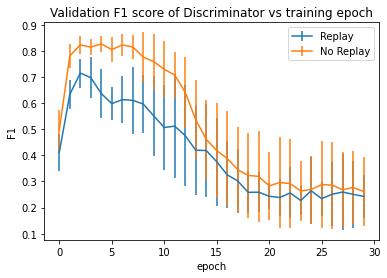

In [25]:
mf1_replay = np.mean(all_replay,axis = 0)
mf1_noreplay = np.mean(all_noreplay,axis = 0)

sf1_replay = np.std(all_replay,axis = 0)
sf1_noreplay = np.std(all_noreplay,axis = 0)

plt.errorbar(range(epochs),mf1_replay,sf1_replay)
plt.errorbar(range(epochs),mf1_noreplay,sf1_noreplay)
plt.legend(["Replay", "No Replay"])
plt.title("Validation F1 score of Discriminator vs training epoch")
plt.xlabel("epoch")
plt.ylabel("F1")
plt.savefig("replay_comparison.png", dpi = 800)

In [83]:
device = "cuda"
if use_dataset == "MNIST":
    gen = ConvGenerator(latent_size = latent_size,normalize = False)
    disc = ConvDiscriminator(normalize= False)
elif use_dataset == "CIFAR10":
    gen = ConvGeneratorCIFAR(latent_size = latent_size,normalize = False)
    disc = ConvDiscriminatorCIFAR(normalize= False)
    
gen.eval()
disc.eval()
gen.load_state_dict(torch.load("./models/novelty_gan_MNIST_replay_False_best_generator.model"))
disc.load_state_dict(torch.load("./models/novelty_gan_MNIST_replay_False_best_discriminator.model"))
gen.to(device)
disc.to(device)

evaluate_model(disc,test_loader)


(array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], dtype=float32),
 array([0, 0, 0, ..., 0, 0, 0]),
 0.891832229580574,
 0.8244897959183674,
 0.8568398727465536)

In [82]:
device = "cuda"
gen = ConvGenerator(latent_size = latent_size,normalize = False)
disc = ConvDiscriminator(normalize= False)
gen.eval()
disc.eval()
gen.load_state_dict(torch.load("./models/novelty_gan_MNIST_replay_True_best_generator.model"))
disc.load_state_dict(torch.load("./models/novelty_gan_MNIST_replay_True_best_discriminator.model"))
gen.to(device)
disc.to(device)

evaluate_model(disc,test_loader)


(array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], dtype=float32),
 array([1, 0, 0, ..., 0, 0, 0]),
 0.7275720164609053,
 0.9020408163265307,
 0.8054669703872437)

In [11]:
#positive == no anomaly
#negative == anomaly

#false positive == missed anomalies
#false negative  == normal confused for anomalies
#High precision == few missed anomalies
#High recall == few false alarms

In [12]:
flat_images = np.concatenate([d[0].reshape(-1,28*28) for d in train_loader])

In [13]:
from model import *
from utils import *
baseline = BaselineModel(pca_components = 5, gmm_components=5, use_pca=False)

baseline.fit(flat_images)
evaluate_baseline(baseline,test_loader, vsize = 28*28)

(array([0., 0., 0., ..., 0., 0., 0.]),
 array([0, 0, 0, ..., 0, 0, 0]),
 0.9979423868312757,
 0.49489795918367346,
 0.6616643929058663)

In [14]:
baseline = BaselineModel(pca_components = 60, gmm_components=5, use_pca=True)

baseline.fit(flat_images)
evaluate_baseline(baseline,test_loader, vsize = 28*28)

(array([0., 0., 0., ..., 0., 1., 0.]),
 array([0, 0, 0, ..., 0, 1, 0]),
 0.8072487644151565,
 0.5,
 0.6175173282923755)

In [15]:
baseline.pc.explained_variance_ratio_.sum()

0.8985921

In [43]:
preds, labels, X = get_test_disc_pred(disc,test_loader,return_x=True)
labels = torch.cat(labels)
preds = torch.cat(preds)
X = torch.cat(X)

In [44]:
mistakes = np.where(labels.flatten() != np.round(preds.flatten()))[0]

sample_dir = "./mistakes/"
os.makedirs(sample_dir, exist_ok=True)
def save_images(index, image_tensors, show=True, prefix = ""):
    fake_images = torch.Tensor(image_tensors)
    fake_fname = prefix+'images-{0:0=4d}.png'.format(index)
    save_image(fake_images, os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images, nrow=8).permute(1, 2, 0))



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Saving false_negatives_images-0000.png
Saving false_positives_images-0000.png


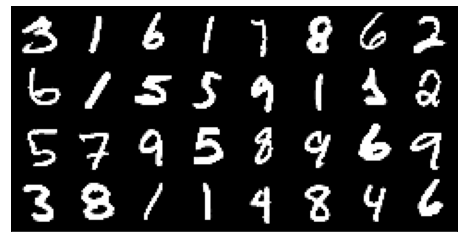

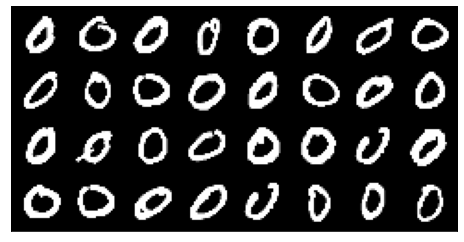

In [78]:
false_negatives = mistakes[np.where(labels[mistakes]!=0)]
false_positives = mistakes[np.where(labels[mistakes]==0)]


save_images(0, X[false_negatives[np.random.choice(len(false_negatives), size = (32))]], prefix = "false_negatives_")

save_images(0, X[false_positives[np.random.choice(len(false_positives), size = (32))]], prefix = "false_positives_")

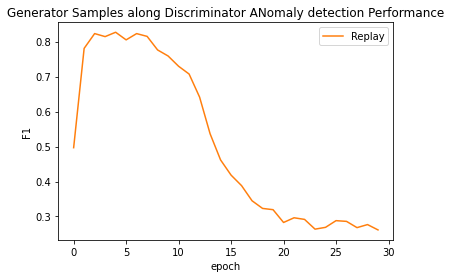

In [124]:
plt.plot(range(epochs),mf1_noreplay, c = "C1")
plt.legend(["Replay"])
plt.title("Generator Samples along Discriminator Anomaly detection F2")
plt.xlabel("epoch")
plt.ylabel("F1")
plt.savefig("replay_comparison.png", dpi = 800)